In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

c:\Users\burka\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()


In [2]:
place_name = "Kadıköy, İstanbul, Turkey"
graph = ox.graph_from_place(place_name, network_type='drive')

place_polygon = ox.geocode_to_gdf(place_name)
place_polygon = place_polygon.to_crs(epsg=32636) 
place_polygon["geometry"] = place_polygon.buffer(1000) 
place_polygon = place_polygon.to_crs(epsg=4326) 

graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='drive')

edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.columns

edges.crs # Check the CRS of the edges GeoDataFrame

graph_proj = ox.project_graph(graph)

nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True) #devamına bak

CRS(edges_proj.crs).to_epsg()



32635

In [3]:
placename = "Ülker Stadyumu"
geocoded_place = ox.geocode_to_gdf(placename)
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))
origin = geocoded_place["geometry"].centroid.values[0]


In [4]:
target_place = "Marmara Yelken Kulübü"
geocoded_place = ox.geocode_to_gdf(target_place)
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))
destination = geocoded_place["geometry"].centroid.values[0]

In [5]:
orig_node_id = ox.distance.nearest_nodes(graph_proj, origin.x, origin.y)
target_node_id = ox.distance.nearest_nodes(graph_proj, destination.x, destination.y)

orig_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=nodes_proj.crs)

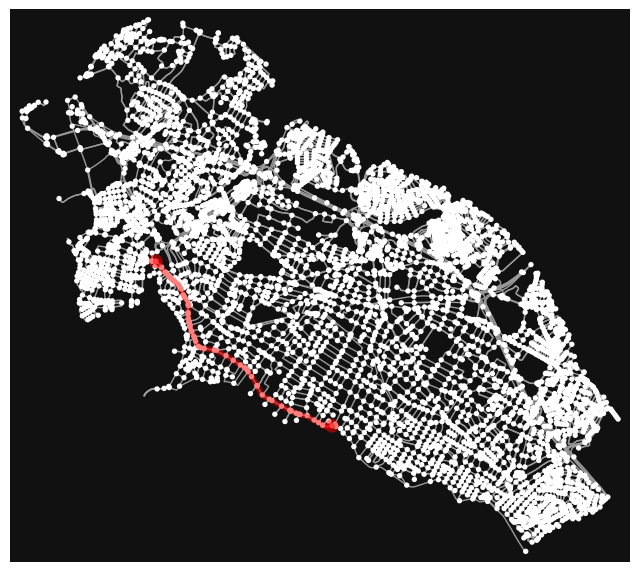

In [6]:
route = nx.shortest_path(G=graph_proj, source=orig_node_id, target=target_node_id, weight='length')

fig, ax = ox.plot_graph_route(graph_proj, route)

In [7]:
from shapely.geometry import LineString, Point
route_nodes = nodes_proj.loc[route]
route_line = LineString(list(route_nodes["geometry"].values))

route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

route_geom.loc[0, 'osmids'] = str(list(route_nodes.index.values))

route_geom['length_m'] = route_geom.length

tags = {'building': True}
buildings = ox.geometries_from_place(place_name, tags)

buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

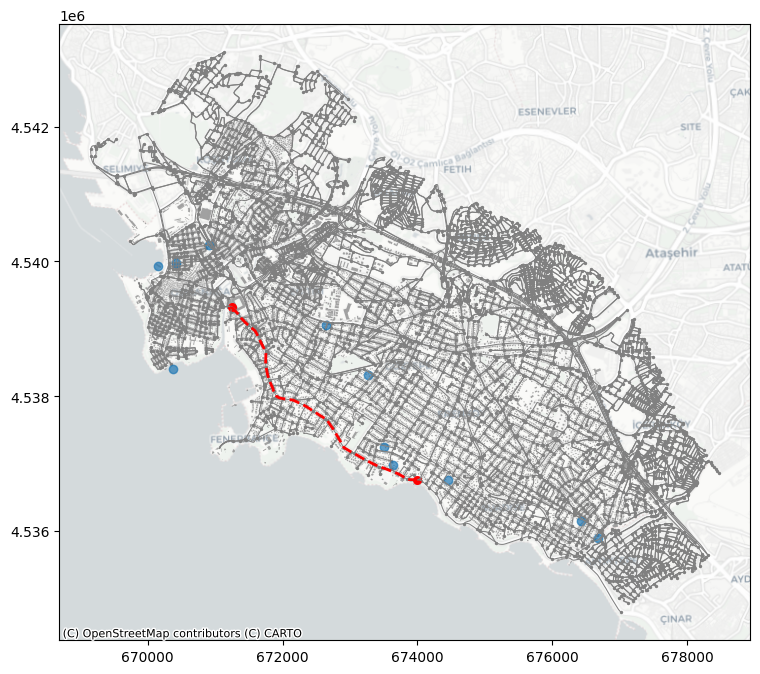

In [8]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot edges and nodes
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='gray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=30, color='red')

# Add basemap
ctx.add_basemap(ax, crs=buildings_proj.crs, source=ctx.providers.CartoDB.Positron)